In [1]:
import torch
import torch.nn.functional as F
import numpy as np                 # import numpy
import matplotlib.pyplot as plt    # import matplotlib
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import h5py
import scipy
from scipy.signal import find_peaks
from IPython.display import Image

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [2]:
class load_dataset(Dataset):
    def __init__(self, path,device):
        data = scipy.io.loadmat(path)['imagingData']['samples'][0,0]
        self.y = torch.zeros((len(data), data[0].shape[0]*data[0].shape[1]), device=device)
        for i in range(len(data)):
          self.y[i] = torch.tensor(data[i].flatten())
        self.y = torch.unsqueeze(self.y, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.y[idx]

# create dataset
dataset = load_dataset(r'./data.mat',device = device)
print(dataset[0].shape)

torch.Size([1, 21054])


In [3]:
def vis_code(x):
    x = x.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(20,3))
    for c in range(x.shape[0]):
        xc = x[c,:]
        nz_x = np.where(xc>0)[0]
        plt.plot(np.zeros(xc.shape), "black")
        plt.stem(nz_x, xc[nz_x], label="x{}".format(c+1), linefmt="{}".format(color[c]), markerfmt="o{}".format(color[c]), basefmt="black", use_line_collection=True)
        plt.legend()
        plt.xlabel("Time [ms]")
    return

def vis_code_est(x, xhat):
    x = x.clone().detach().cpu().numpy()
    xhat = xhat.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(20,3))

    for c in range(x.shape[0]):
        xc = x[c,:]
        nz_x = np.where(xc>0)[0]
        plt.plot(np.zeros(xc.shape), "black")
        plt.stem(nz_x, xc[nz_x], label="x{}".format(c+1), linefmt="black", markerfmt="o{}".format(color[c]), basefmt="black", use_line_collection=True)
        xchat = xhat[c,:]
        nz_xhat = np.where(xchat>0)[0]
        plt.stem(nz_xhat, xchat[nz_xhat], label="xhat{}".format(c+1), linefmt="-.{}".format(color[c]), markerfmt="*{}".format(color[c]), basefmt="black", use_line_collection=True)
        plt.legend()
        plt.title("x")
        plt.legend()
        plt.xlabel("Time [ms]")
    return

def vis_filters(h):
    h = h.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(5,2))
    for c in range(h.shape[0]):
        plt.plot(h[c,0,:], label="true", color=color[c])
    plt.title("h")
    plt.xlabel("Time [ms]")
    return

def vis_filter_est(h, h_init, h_hat):
    if h is not None:
      h = h.clone().detach().cpu().numpy()
    h_init = h_init.clone().detach().cpu().numpy()
    h_hat = h_hat.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(15,3))
    for c in range(h_init.shape[0]):
        plt.subplot(1,h_init.shape[0],c+1)
        if h is not None:
          plt.plot(h[c,0,:], label="true", color="black")
        plt.plot(h_init[c,0,:], "--", label="init", color="gray")
        plt.plot(h_hat[c,0,:], label="est", color=color[c])
        plt.title("h{}".format(c+1))
        plt.xlabel("Time [ms]")
        plt.legend()
    return

def vis_data(y):
    y = y.clone().detach().cpu().numpy()
    plt.figure(figsize=(20,3))
    plt.plot(y, label="raw", color="black")
    plt.title("y")
    plt.xlabel("Time [ms]")
    plt.legend()
    return

def vis_data_est(y,y_hat):
    y = y.clone().detach().cpu().numpy()
    y_hat = y_hat.clone().detach().cpu().numpy()
    plt.figure(figsize=(20,3))
    plt.plot(y, label="raw", color="black")
    plt.plot(y_hat, label="denoised", color="orange")
    plt.title("y")
    plt.xlabel("Time [ms]")
    plt.legend()
    return

def vis_data_separated_est(hx1,hx2):
    hx1 = hx1.clone().detach().cpu().numpy()
    hx2 = hx2.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(20,3))
    plt.plot(hx1, label="1", color=color[0])
    plt.plot(hx2, label="2", color=color[1])
    plt.title("y")
    plt.xlabel("Time [ms]")
    plt.legend()

def vis_miss_false(missed_per_list, false_per_list):
  plt.figure(figsize=(10,5))
  plt.plot(missed_per_list, false_per_list, color="black", label="CRsAE")
  plt.xlabel("True Miss [%]")
  plt.ylabel("False Alarm [%]")
  plt.ylim(0,1.1*np.max(false_per_list))
  plt.xlim(0,1.1*np.max(missed_per_list))
  plt.legend()
  return

def load_filters(device):
    return torch.load("data/h_sim_2.pt").to(device)

def load_h_init_harris(device):
    return torch.load("data/h_init_harris.pt").to(device)

def load_y_harris(device):
    return torch.load("data/y_harris.pt").to(device)

def load_y_series_harris(device):
    return torch.load("data/y_series_harris.pt").to(device)

# create distance measure for dictionary
def compute_err_h(h, h_hat):
    h = h.clone().detach()
    h_hat = h_hat.clone().detach()

    err = torch.zeros(h.shape[0])
    for c in range(h.shape[0]):
        corr = torch.sum(h[c, 0, :] * h_hat[c, 0, :])
        err[c] = torch.sqrt(torch.abs(1 - corr) ** 2)
    return err

def initialize_filter(H):
  flag = 1
  while flag:
    H_init = H + 0.4 * torch.randn(H.shape, device=device)
    H_init = F.normalize(H_init, p=2, dim=-1)
    if torch.max(compute_err_h(H, H_init)) < 0.5:
      if torch.min(compute_err_h(H, H_init)) > 0.4:
        flag = 0

  return H_init

In [4]:
class CRsAE1D(torch.nn.Module):
    def __init__(self, hyp, H=None):
        super(CRsAE1D, self).__init__()

        self.T = hyp["T"]            # number of encoder unfolding
        self.L = hyp["L"]            # 1/L is the step size in the encoder
        self.C = hyp["C"]            # number of filters
        self.K = hyp["K"]            # legnth of the filters
        self.lam = hyp["lam"]        # lambda (regularization parameter)
        self.device = hyp["device"]  # device (i.e., cpu, cuda0)

        # initialize the filter H
        if H is None:
            # initialize with random normal
            H = torch.randn((self.C, 1, self.K), device=self.device)
            # normalize that each filter has norm 1
            H = F.normalize(H, p=2, dim=-1)
        # register the filters as weights of
        # the neural network so that to be trainable.
        self.register_parameter("H", torch.nn.Parameter(H))
        # create ReLU
        self.relu = torch.nn.ReLU()

    def get_param(self, name):
        # get parameters with name
        return self.state_dict(keep_vars=True)[name]

    def normalize(self):
        # normalize the filters
        self.get_param("H").data = F.normalize(self.get_param("H").data, p=2, dim=-1)

    def H_operator(self, x):
        return F.conv_transpose1d(x, self.get_param("H"))

    def HT_operator(self, x):
        return F.conv1d(x, self.get_param("H"))

    def encoder(self, y):
        enc_dim = F.conv1d(y, self.get_param("H")).shape[-1]

        x_old = torch.zeros(y.shape[0], self.C, enc_dim, device=self.device)
        x_tmp = torch.zeros(y.shape[0], self.C, enc_dim, device=self.device)
        x_new = torch.zeros(y.shape[0], self.C, enc_dim, device=self.device)
        s_old = torch.tensor(1, device=self.device).float()

        # T recurrent steps
        for t in range(self.T):
            res = y - self.H_operator(x_tmp)

            x_new = x_tmp + self.HT_operator(res) / self.L

            x_new = self.relu(x_new - self.lam / self.L)

            s_new = (1 + torch.sqrt(1 + 4 * s_old * s_old)) / 2
            x_tmp = x_new + (s_old - 1) / s_new * (x_new - x_old)

            x_old = x_new
            s_old = s_new
        return x_new

    def decoder(self, x):
        return F.conv_transpose1d(x, self.get_param("H"))

    def forward(self, y):
        # encoder
        x = self.encoder(y)
        # decoder
        y_hat = self.decoder(x)
        return y_hat, x

    def separate(self,y):
        with torch.no_grad():
            # encoder
            x = self.encoder(y)

            hx_separate = torch.zeros((y.shape[0], self.C, y.shape[-1]), device=self.device)
            for c in range(self.C):
                xc = torch.unsqueeze(x[:,c,:], dim=1)
                hc = torch.unsqueeze(self.get_param("H")[c,:,:],dim=0)
                hx_separate[:,c,:] =  torch.squeeze(F.conv_transpose1d(xc, hc),dim=1)

        return hx_separate

In [5]:
##########################
######## step 3.1. #######
##### build network ######
##########################

##########################
####### step 3.1.1 ######
##########################
# fill in the gaps
net_hyp = {"T": 800,                 # number of encoder unfolding
           "L": 10,                  # 1/L is the step size in the encoder
           "C": 1,                 # number of filters
           "K": 5,                  # legnth of the filters
           "lam": 0.7,
           "device": device
           }
#H_init = initialize_filter(dataset.H.clone())
##########################
####### step 3.1.2. ######
##########################
# create the newtork with hyperparameters define above, and also H=H_init
net = CRsAE1D(net_hyp)

##########################
######## step 3.2. #######
##########################
# training parameters
train_hyp = {"batch_size": 16, "num_epochs": 10, "lr": 1e-2, "shuffle": True}
# data loader
train_loader = DataLoader(dataset, shuffle=train_hyp["shuffle"], batch_size=train_hyp["batch_size"])
##########################
######## step 3.3. #######
##########################
# criterion
criterion = torch.nn.MSELoss()
##########################
######## step 3.4. #######
##########################
# optimizer
optimizer = optim.Adam(net.parameters(), lr=train_hyp["lr"], eps=1e-3)

In [6]:
##########################
####### step 3.5. ########
######## training ########
##########################

#print("\n start training!")
#print("initial err_H:{:4f}\n".format(torch.mean(compute_err_h(dataset.H, net.get_param("H")))))
# each loop is one pass over the whole dataset
for epoch in tqdm(range(train_hyp["num_epochs"]), disable=True):
    loss_all = 0
    # each loop is a mini-batch
    for idx, y in tqdm(enumerate(train_loader), disable=False):
        # load data input the device
        y = y.to(device)

        ##########################
        ###### step 3.5.1. #######
        ##########################
        # run the network in forward net(y) to get y_hat and x_hat
        y_hat, _= net(y)

        ##########################
        ####### step 3.5.2. ######
        ##########################
        # compute loss using the created criterion
        loss = criterion(y, y_hat)
        loss_all += float(loss.item())

        ##########################
        ####### step 3.5.3 #######
        ##########################
        # set the gradients in the optimizer to zero (optimizer.zero_grad())
        optimizer.zero_grad()
        # do backward on the loss
        loss.backward()
        # take a step with the optimizer
        optimizer.step()

        # normalize filters
        net.normalize()

        #err_h = compute_err_h(dataset.H, net.get_param("H"))
    print("Epoch [{}/{}]loss:{:.4f}\n".format(epoch+1,train_hyp["num_epochs"],loss_all))

4it [00:05,  1.49s/it]


Epoch [1/10]loss:0.2993



4it [00:03,  1.20it/s]


Epoch [2/10]loss:0.2970



4it [00:03,  1.20it/s]


Epoch [3/10]loss:0.2944



4it [00:03,  1.21it/s]


Epoch [4/10]loss:0.2933



4it [00:03,  1.21it/s]


Epoch [5/10]loss:0.2918



4it [00:03,  1.22it/s]


Epoch [6/10]loss:0.2901



4it [00:03,  1.21it/s]


Epoch [7/10]loss:0.2901



4it [00:03,  1.20it/s]


Epoch [8/10]loss:0.2889



4it [00:03,  1.22it/s]


Epoch [9/10]loss:0.2895



4it [00:03,  1.22it/s]

Epoch [10/10]loss:0.2909



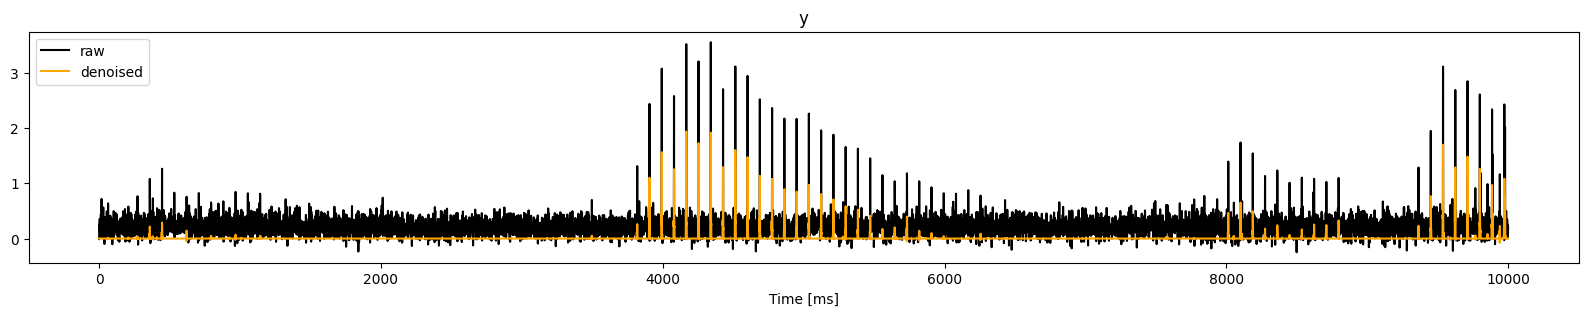

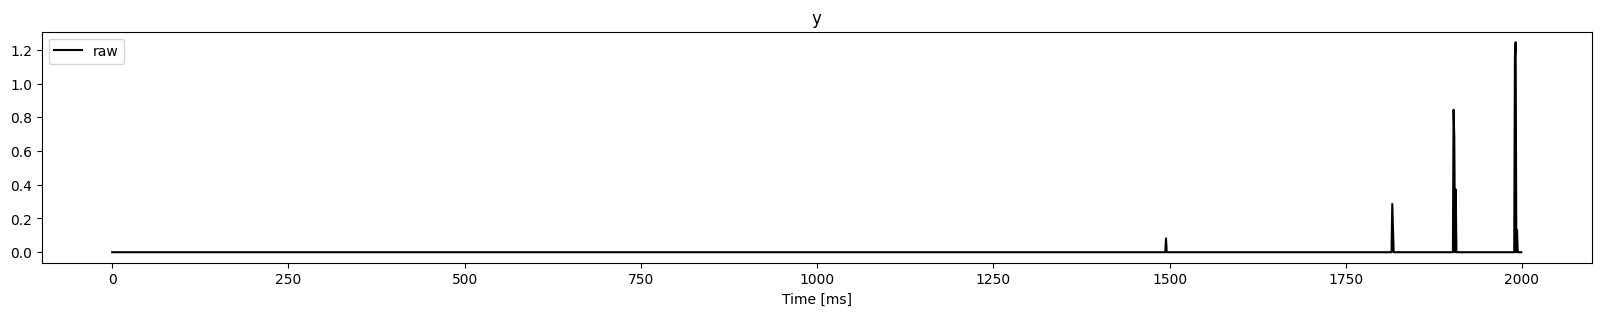

In [7]:
##########################
####### step 3.6. ########
##########################
yi = dataset[0:3]
yi_hat, xi_hat = net(yi)

# this function gets y and gives [h1 * x1, h2 * x2]
#hx = net.separate(yi)

# visualize the filters
#vis_filter_est(dataset.H, H_init, net.get_param("H"))

# visualize the data
vis_data_est(yi[1,0][0:10000], yi_hat[1,0][0:10000])

# visualize Hx1 and Hx2
#vis_data_separated_est(hx[0][0], hx[0][1])
vis_data(xi_hat[1,0][2000:4000])
#vis_data(yi_hat[0])

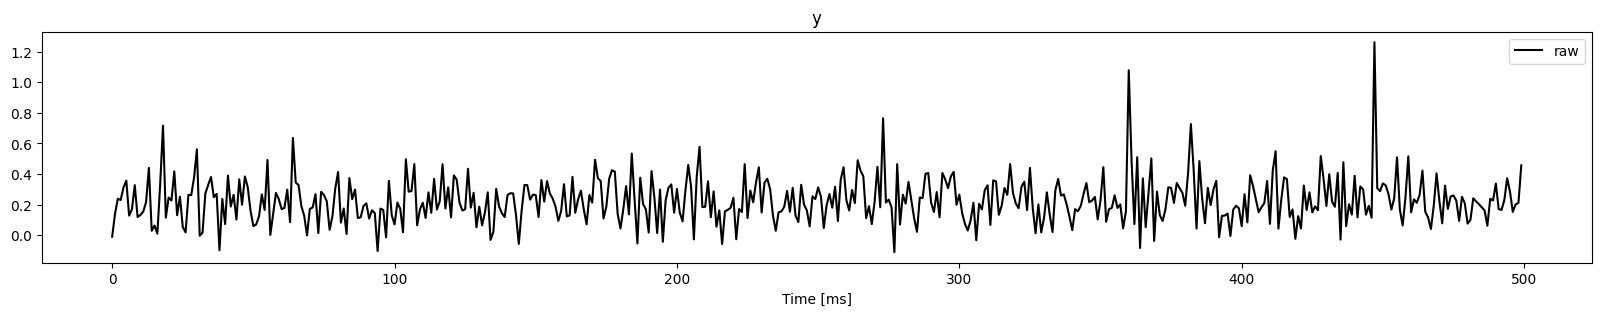

In [8]:
yi = dataset[0:3]
vis_data(yi[1,0][0:500])

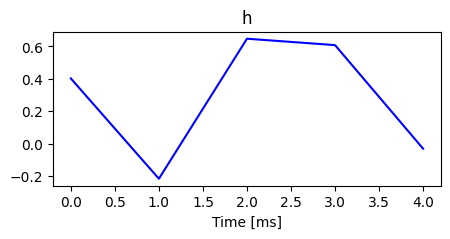

In [9]:
vis_filters(net.get_param("H"))

In [14]:
torch.save(net.state_dict(),'real_data_trained_network.pth')